# Project: Image Classification and Regression - Marion Favre d'Echallens

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.patches as patches
import keras

Using TensorFlow backend.


In [2]:
#Keras modules
from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Dropout, Flatten, Input, UpSampling2D
from keras.optimizers import SGD, Adam

Useful functions and example

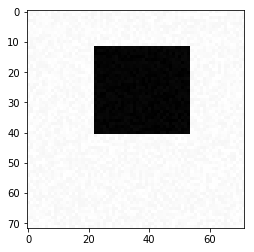

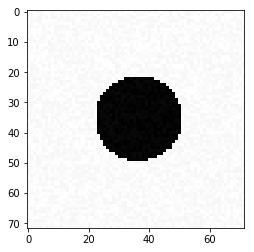

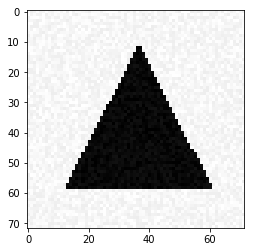

In [3]:
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]


#### 3) SIMPLE CLASSIFICATION: RECTANGLE(0), DISK(1), TRIANGLE(2)

##### a) STOCHASTIC GRADIENT OPTIMIZER

We create the training dataset. We need to reshape Y_train so that it has the correct shape reprensenting the three classes in order to fit the model.

In [5]:
[X_train, Y_train] = generate_dataset_classification(300, 20) 
# Convert labels to categorical one-hot encoding
Y_train = np_utils.to_categorical(Y_train, num_classes=3)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


We create a first model using the Stochastic Gradient as an optimizer. To define the optimizer, we keep the default parameters. The model is made of two Dense layers. The second one has to contain 3 filters as we have a three classes classification problem. The number of filters of the first one has been set to 128 after testing different figures and observing the final accuracy and loss of the model. We compile the model with the loss function "categorical_crossentropy" which is adapted to our problem of multiple class classification and we also compute its accuracy.

We choose a batch size of 32 and use 20 epochs.

In [23]:
#Stochastic Gradient Descent 
# For a three-class classification problem
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(5184,)))
model.add(Dense(3, activation='softmax'))
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.5, nesterov=False)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd,metrics=['accuracy']) 

#training the model  
model.fit(X_train, Y_train, epochs=20, batch_size=32)

Epoch 1/20
300/300 [==============================] - 1s 3ms/step - loss: 1.6237 - acc: 0.4500
Epoch 2/20
300/300 [==============================] - 0s 556us/step - loss: 0.9047 - acc: 0.5367
Epoch 3/20
300/300 [==============================] - 0s 626us/step - loss: 0.7875 - acc: 0.6600
Epoch 4/20
300/300 [==============================] - 0s 670us/step - loss: 0.6134 - acc: 0.7400
Epoch 5/20
300/300 [==============================] - 0s 616us/step - loss: 0.5789 - acc: 0.7300
Epoch 6/20
300/300 [==============================] - 0s 633us/step - loss: 0.4893 - acc: 0.8400
Epoch 7/20
300/300 [==============================] - 0s 593us/step - loss: 0.5037 - acc: 0.7100
Epoch 8/20
300/300 [==============================] - 0s 643us/step - loss: 0.4756 - acc: 0.8233
Epoch 9/20
300/300 [==============================] - 0s 583us/step - loss: 0.4440 - acc: 0.8067
Epoch 10/20
300/300 [==============================] - 0s 570us/step - loss: 0.3498 - acc: 0.8700
Epoch 11/20
300/300 [==========

The final accuracy is very good: 0.91. Thus the model can be validated.

In [34]:
#testing
X_test1 = generate_a_disk() #classe 1
X_test1 = X_test1.reshape(1, X_test1.shape[0])
model.predict(X_test1,batch_size=32, verbose=0)

array([[0., 1., 0.]], dtype=float32)

In [31]:
#[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [35]:
#loss and accuracy  à garder???
#model.evaluate(X_test,Y_test,batch_size=32) 

300/300 [==============================] - 0s 170us/step


[2.415025952657064, 0.31666666686534883]

The test of the model doesn't give always the right answer on testing data although it has a good accuracy on training data.

##### B) ADAM OPTIMIZER

Let's now build and train a neural networks with adam optimizer.

In [40]:
# For a three-class classification problem
model_A = Sequential()
model_A.add(Dense(3, activation='softmax',input_shape = (5184,)))
model_A.compile(loss='categorical_crossentropy', 
              optimizer='adam',metrics=['accuracy']) 
#training the model
model_A.fit(X_train, Y_train, epochs=20, batch_size=32)


Epoch 1/20
300/300 [==============================] - 1s 2ms/step - loss: 2.0562 - acc: 0.3967
Epoch 2/20
300/300 [==============================] - 0s 300us/step - loss: 0.8806 - acc: 0.5633
Epoch 3/20
300/300 [==============================] - 0s 453us/step - loss: 0.5921 - acc: 0.7133
Epoch 4/20
300/300 [==============================] - 0s 326us/step - loss: 0.4092 - acc: 0.9067
Epoch 5/20
300/300 [==============================] - 0s 283us/step - loss: 0.3449 - acc: 0.9400
Epoch 6/20
300/300 [==============================] - 0s 436us/step - loss: 0.4254 - acc: 0.7933
Epoch 7/20
300/300 [==============================] - 0s 253us/step - loss: 0.4579 - acc: 0.7700
Epoch 8/20
300/300 [==============================] - 0s 343us/step - loss: 0.2701 - acc: 0.9000
Epoch 9/20
300/300 [==============================] - 0s 393us/step - loss: 0.1945 - acc: 0.9600
Epoch 10/20
300/300 [==============================] - 0s 373us/step - loss: 0.1825 - acc: 0.9733 0s - loss: 0.1746 - acc: 0.973


In [41]:
#testing
X_test1 = generate_a_disk() #classe 1
X_test1 = X_test1.reshape(1, X_test1.shape[0])
model_A.predict(X_test1,batch_size=32, verbose=0)

array([[0., 1., 0.]], dtype=float32)

In [42]:
#model_A.evaluate(X_test, Y_test, batch_size  =32)

300/300 [==============================] - 0s 773us/step


[2.6416515731811523, 0.35666666587193807]

Adam optimizer seems to have a better accurracy than the SGD optimizer over the training data and on the testing data.

### 4) VISUALIZATION OF THE SOLUTION

Let's visualize the weights of the classifiers for both previous models.

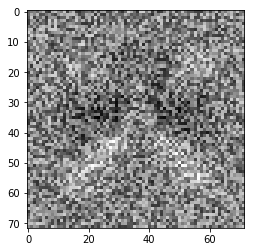

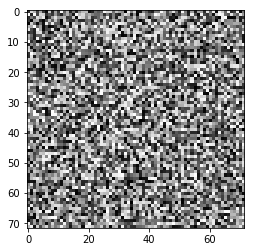

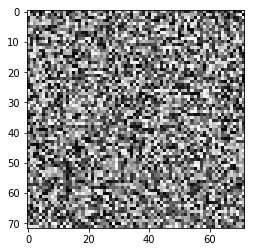

In [43]:
# SGD optimizer
W = model.layers[0].get_weights()
plt.imshow(W[0][:,0].reshape(72,72), cmap='gray')
plt.show()
plt.imshow(W[0][:,1].reshape(72,72), cmap='gray')
plt.show()
plt.imshow(W[0][:,2].reshape(72,72), cmap='gray')
plt.show()

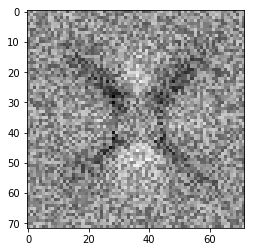

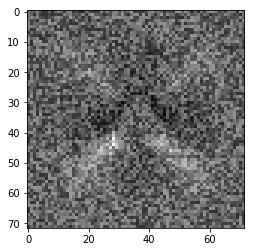

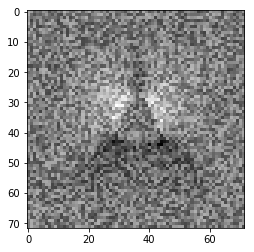

In [44]:
# Adam optimizer
W = model_A.layers[0].get_weights()
plt.imshow(W[0][:,0].reshape(72,72), cmap='gray')
plt.show()
plt.imshow(W[0][:,1].reshape(72,72), cmap='gray')
plt.show()
plt.imshow(W[0][:,2].reshape(72,72), cmap='gray')
plt.show()

For the SGD optimizer we notice some shape on the first picture while the two others are totally blurred. However, we distinguish shapes on all pictures for the Adam optimizer. 
Meaning of the weights ??

### 5) MORE DIFFICULT CLASSIFICATION PROBLEM

In this part, we consider a data set in which the free location of the shapes within the image is allowed.

In [45]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
Y_train = np_utils.to_categorical(Y_train, num_classes=3)


Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


First, we train our two previous models on this new dataset and observe the results.

In [46]:
#Stochastic Gradient Descent 
# For a three-class classification problem
model = Sequential()
model.add(Dense(168, activation='relu', input_shape = (5184,)))
model.add(Dense(3, activation='softmax'))
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.5, nesterov=False)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd,metrics=['accuracy']) 

#training the model  
model.fit(X_train, Y_train, epochs=20, batch_size=32)

Epoch 1/20
300/300 [==============================] - 1s 3ms/step - loss: 6.3553 - acc: 0.3367
Epoch 2/20
300/300 [==============================] - 0s 790us/step - loss: 2.6611 - acc: 0.4000
Epoch 3/20
300/300 [==============================] - 0s 673us/step - loss: 1.0632 - acc: 0.4267
Epoch 4/20
300/300 [==============================] - ETA: 0s - loss: 1.0534 - acc: 0.363 - 0s 916us/step - loss: 1.0586 - acc: 0.3667
Epoch 5/20
300/300 [==============================] - 0s 853us/step - loss: 0.9912 - acc: 0.5033
Epoch 6/20
300/300 [==============================] - 0s 746us/step - loss: 1.0043 - acc: 0.4700
Epoch 7/20
300/300 [==============================] - 0s 606us/step - loss: 1.0712 - acc: 0.3967
Epoch 8/20
300/300 [==============================] - 0s 796us/step - loss: 0.9746 - acc: 0.4767
Epoch 9/20
300/300 [==============================] - 0s 670us/step - loss: 0.9001 - acc: 0.5333
Epoch 10/20
300/300 [==============================] - 0s 703us/step - loss: 0.9633 - acc: 

In [47]:
#loss and accuracy
model.evaluate(X_test, Y_test) #SGD optimizer

300/300 [==============================] - 0s 936us/step


[1.374732066790263, 0.38333333293596905]

In [48]:
#Adam optimizer
# For a three-class classification problem
model_A = Sequential()
model_A.add(Dense(3, activation='softmax',input_shape = (5184,)))
model_A.compile(loss='categorical_crossentropy', 
              optimizer='adam',metrics=['accuracy']) 
#training the model
model_A.fit(X_train, Y_train, epochs=20, batch_size=32)

Epoch 1/20
300/300 [==============================] - 1s 3ms/step - loss: 2.8987 - acc: 0.3233
Epoch 2/20
300/300 [==============================] - 0s 410us/step - loss: 1.4333 - acc: 0.3433
Epoch 3/20
300/300 [==============================] - 0s 247us/step - loss: 1.1350 - acc: 0.4367
Epoch 4/20
300/300 [==============================] - 0s 326us/step - loss: 1.1116 - acc: 0.4367
Epoch 5/20
300/300 [==============================] - 0s 360us/step - loss: 1.0392 - acc: 0.5000
Epoch 6/20
300/300 [==============================] - 0s 253us/step - loss: 1.0286 - acc: 0.4800
Epoch 7/20
300/300 [==============================] - 0s 303us/step - loss: 0.8619 - acc: 0.6033
Epoch 8/20
300/300 [==============================] - 0s 283us/step - loss: 0.8583 - acc: 0.5767
Epoch 9/20
300/300 [==============================] - 0s 260us/step - loss: 0.9432 - acc: 0.5300
Epoch 10/20
300/300 [==============================] - 0s 233us/step - loss: 0.8415 - acc: 0.6100
Epoch 11/20
300/300 [==========

In [49]:
model_A.evaluate(X_test, Y_test) #Adam optimizer

300/300 [==============================] - 0s 996us/step


[0.8246513430277507, 0.5800000007947286]

We observe that the previous models are less efficient when regarding the accuracy on the training data but they seem to perform better on testing data. Adam optimizer seems also better than SGD.

Let's now create a new model using convolutional 2Dlayer (16 filters 5x5), one pooling 2Dlayer and a Dense layer. We use a Flatten layer as a "reshape" layer before the final Dense layer. As we saw before that Adam optimizer was the best, we use it to compile the model as well as the loss categorical_crossentropy. activation meaning ??

In order to fit the model, we reshape the data as followed: 

In [50]:
#creating a new model  
X_trainr=X_train.reshape(X_train.shape[0],72,72,1)
print(X_trainr.shape)
Y_trainr=Y_train
print(Y_trainr.shape)

(300, 72, 72, 1)
(300, 3)


In [51]:
##Convolution2D
model2 = Sequential() 
model2.add(Conv2D(16, (5,5), activation='relu',input_shape=(72,72,1)))
print(model2.output_shape)

model2.add(MaxPooling2D(pool_size =(2,2)))
print(model2.output_shape)
model2.add(Flatten())
print(model2.output_shape)
model2.add(Dense(3,activation='softmax'))
print(model2.output_shape)


model2.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model2.fit(X_trainr, Y_trainr, epochs=20, batch_size=32)

(None, 68, 68, 16)
(None, 34, 34, 16)
(None, 18496)
(None, 3)
Epoch 1/20
300/300 [==============================] - 2s 7ms/step - loss: 1.0908 - acc: 0.3967
Epoch 2/20
300/300 [==============================] - 1s 4ms/step - loss: 0.9184 - acc: 0.6033
Epoch 3/20
300/300 [==============================] - 1s 3ms/step - loss: 0.7689 - acc: 0.7600
Epoch 4/20
300/300 [==============================] - 1s 3ms/step - loss: 0.6902 - acc: 0.7433
Epoch 5/20
300/300 [==============================] - 1s 4ms/step - loss: 0.5912 - acc: 0.8167
Epoch 6/20
300/300 [==============================] - 1s 3ms/step - loss: 0.5360 - acc: 0.8300
Epoch 7/20
300/300 [==============================] - 1s 4ms/step - loss: 0.5169 - acc: 0.8400
Epoch 8/20
300/300 [==============================] - 1s 4ms/step - loss: 0.4514 - acc: 0.8767
Epoch 9/20
300/300 [==============================] - 1s 4ms/step - loss: 0.4160 - acc: 0.8967
Epoch 10/20
300/300 [==============================] - 1s 5ms/step - loss: 0.3902 -

In [52]:
X_testr = X_test.reshape(X_test.shape[0],72,72,1)
print(X_testr.shape)

(300, 72, 72, 1)


In [53]:
model2.evaluate(X_testr, Y_test)

300/300 [==============================] - 1s 3ms/step


[0.6941080514589946, 0.7300000007947286]

The value of the lost function when using the deep network is: 0.69 and the accuracy is 0.73. We conclude that the performances on training and testing datasets of this deep network are really better than these of the both previous small networks.

### 6) A REGRESSION PROBLEM

In this section we want to predict the image locations of the vertices of a triangle. 
First we need to normalize the vertices with the following function:

In [54]:
#normalize vertices
def normer(Y):
    for i in range(len(Y)):
        a = math.sqrt(Y[i,0]**2 + Y[i,1]**2)
        b = math.sqrt(Y[i,2]**2 + Y[i,3]**2)
        c = math.sqrt(Y[i,4]**2 + Y[i,5]**2)
        Y[i,:]=[Y[i,0]/a,Y[i,1]/a,Y[i,2]/b,Y[i,3]/b,Y[i,4]/c,Y[i,5]/c]
    return Y


Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


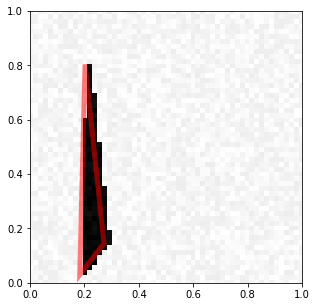

In [55]:
[X_train, Y_train] = generate_dataset_regression(300, 20)
visualize_prediction(X_train[0], Y_train[0])

Let's now build and train a deep networks for this regression problem. We use the adam optimizer with some changed parameters. As a loss function we use the mean squared error which is adapted to the regression problem.

We reshape X_train and normalize Y_train before fittint the model.

In [56]:
X_train2 = X_train.reshape(X_train.shape[0], 72, 72, 1)
Y_train = normer(Y_train)

In [57]:
model_r = Sequential()     ## à améliorer
model_r.add(Conv2D(32, (5, 5), activation='relu', input_shape=(72, 72, 1)))
model_r.add(MaxPooling2D(pool_size=(2, 2)))

model_r.add(Conv2D(32, (5, 5), activation='relu', input_shape=(72, 72, 1)))
model_r.add(MaxPooling2D(pool_size=(2, 2)))
model_r.add(Flatten()) 
model_r.add(Dense(64, activation='relu')) 
#model_r.add(Dense(128, activation='relu')) 
model_r.add(Dense(6)) 

adam = Adam(lr=1e-3, beta_1=0.5, beta_2=0.6, epsilon=0.001, decay=0.1)
model_r.compile(loss='mean_squared_error', 
              optimizer=adam,metrics = ['accuracy'])
model_r.fit(X_train2, Y_train, epochs=20, batch_size=64)


Epoch 1/20
300/300 [==============================] - 5s 17ms/step - loss: 0.2055 - acc: 0.1733
Epoch 2/20
300/300 [==============================] - 3s 11ms/step - loss: 0.0842 - acc: 0.1700
Epoch 3/20
300/300 [==============================] - 3s 11ms/step - loss: 0.0757 - acc: 0.2600
Epoch 4/20
300/300 [==============================] - 4s 12ms/step - loss: 0.0710 - acc: 0.2767
Epoch 5/20
300/300 [==============================] - 3s 12ms/step - loss: 0.0685 - acc: 0.2467
Epoch 6/20
300/300 [==============================] - 3s 11ms/step - loss: 0.0661 - acc: 0.2400
Epoch 7/20
300/300 [==============================] - 3s 11ms/step - loss: 0.0630 - acc: 0.3133
Epoch 8/20
300/300 [==============================] - 4s 12ms/step - loss: 0.0621 - acc: 0.2900
Epoch 9/20
300/300 [==============================] - 4s 12ms/step - loss: 0.0614 - acc: 0.2667
Epoch 10/20
300/300 [==============================] - 3s 11ms/step - loss: 0.0592 - acc: 0.3067
Epoch 11/20
300/300 [==================

In [58]:
[X_test, Y_test] = generate_test_set_regression()
X_test = X_test.reshape(X_test.shape[0], 72, 72, 1)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [59]:
Y_test = normer(Y_test)
model_r.evaluate(X_test, Y_test)

300/300 [==============================] - 2s 5ms/step


[0.06718442410230636, 0.32]

Model to be improved.

### 7) IMAGE DENOISING

In this section, we want to predict a noise free image given a noisy image as input. For that, we modify the functions so that they generate a pair of images with the same caracteristics, but one without noise and one with noise.

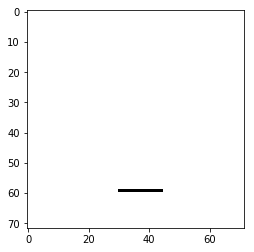

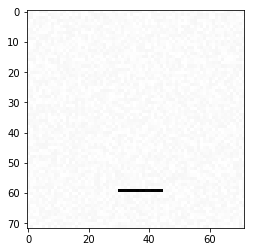

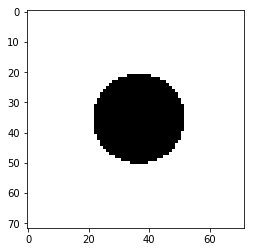

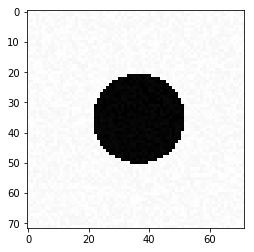

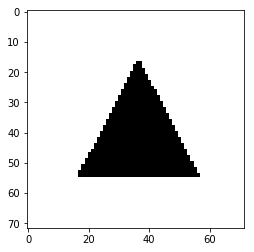

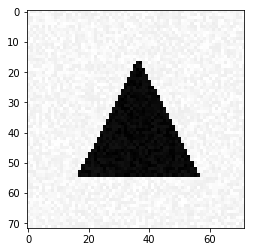

In [60]:
def generate_a_rectangle_pair(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise=0), generate_a_drawing(figsize, U, V, noise)


def generate_a_disk_pair(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise=0), generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle_pair(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata, imdata_noise = generate_a_drawing(figsize, U, V, noise=0),generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]],[imdata_noise, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im, im_noise = generate_a_rectangle_pair(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()
plt.imshow(im_noise.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

im, im_noise = generate_a_disk_pair(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()
plt.imshow(im_noise.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

[im, v], [im_noise,vv] = generate_a_triangle_pair(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()
plt.imshow(im_noise.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification_pair(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    X_noise = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i], X_noise[i] = generate_a_rectangle_pair(noise, free_location)
        elif category == 1: 
             X[i], X_noise[i] = generate_a_disk_pair(noise, free_location)
        else:
            [X[i], V],[X_noise[i], VV]= generate_a_triangle_pair(noise, free_location)
        Y[i] = category
    X = X / 255
    X_noise = (X_noise + noise) / (255 + 2 * noise)
    return [X, X_noise, Y]

Let's create a deep network to solve this problem.

In [61]:
X, X_noise, Y = generate_dataset_classification_pair(
    nb_samples=300, noise=50, free_location=True
)
X_noise = X_noise.reshape(X_noise.shape[0], 72, 72, 1)
X = X.reshape(X.shape[0], 72, 72, 1)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [62]:
X_test, X_noise_test, Y_test = generate_dataset_classification_pair(
    nb_samples=150, noise=50, free_location=True
)
X_noise_test = X_noise_test.reshape(X_noise_test.shape[0], 72, 72, 1)
X_test = X_test.reshape(X_test.shape[0], 72, 72, 1)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


We are going to build an autoencoder that is a network that do autoencoding : compressing and decompressing images by learning automatically from examples.

We need to create a deep network for the encoder and for the decoder: The encoder is made of two convolutional 2D layers and a Polling 2D layer. The decoder is made of two convolutional 2D layers and two UpSampling 2D layers which are needed for the autoencoding (learning).

The autoencoder uses adam optimizer with mean squared error as loss function.

In [64]:
# à modifier??

input_img = Input(shape=(72, 72, 1))  # image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)


x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error',metrics = ['accuracy'])

In [65]:
autoencoder.fit(X_noise, X,
                epochs=10,
                batch_size=32,
                shuffle=True,
                validation_data=(X_noise_test, X_test)
               )

Train on 300 samples, validate on 150 samples
Epoch 1/10
300/300 [==============================] - 17s 57ms/step - loss: 0.1915 - acc: 0.8188 - val_loss: 0.0680 - val_acc: 0.9265
Epoch 2/10
300/300 [==============================] - 15s 49ms/step - loss: 0.0747 - acc: 0.9145 - val_loss: 0.0675 - val_acc: 0.9265
Epoch 3/10
300/300 [==============================] - 14s 45ms/step - loss: 0.0658 - acc: 0.9153 - val_loss: 0.0451 - val_acc: 0.9265
Epoch 4/10
300/300 [==============================] - 14s 46ms/step - loss: 0.0401 - acc: 0.9460 - val_loss: 0.0249 - val_acc: 0.9682
Epoch 5/10
300/300 [==============================] - 14s 48ms/step - loss: 0.0173 - acc: 0.9840 - val_loss: 0.0088 - val_acc: 0.9926
Epoch 6/10
300/300 [==============================] - 14s 48ms/step - loss: 0.0069 - acc: 0.9933 - val_loss: 0.0058 - val_acc: 0.9932
Epoch 7/10
300/300 [==============================] - 23s 76ms/step - loss: 0.0052 - acc: 0.9938 - val_loss: 0.0055 - val_acc: 0.9929
Epoch 8/10
300/3

The accuracy of the model is very good. Let's now look at the reconstructed images without noise from the noisy ones:

(10, 72, 72, 1)


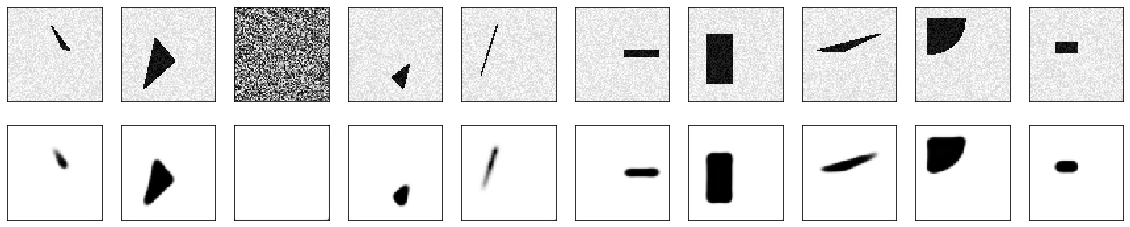

In [67]:
## Denoising result
n = 10
p = 2
decoded_imgs = autoencoder.predict(X_noise_test[p*n:(p+1)*n])
print(decoded_imgs.shape)

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_noise_test[i + p*n].reshape(72, 72))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(72, 72))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Reconstructed images are quite good.